## Importing necessary libraries

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

## import Gold and DXY, preprocess them and create features 

In [119]:
gold = pd.read_csv('data/XAUUSD.csv')
dxy = pd.read_csv('data/DXY.csv')

gold.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11/28/2025,"4,230.63","4,157.57","4,231.51","4,157.15",NaN,1.76%
1,11/27/2025,"4,157.57","4,164.53","4,169.00","4,142.57",NaN,-0.17%
2,11/26/2025,"4,164.59","4,131.15","4,173.70","4,128.99",NaN,0.81%
3,11/25/2025,"4,131.15","4,139.66","4,159.45","4,109.72",NaN,-0.21%
4,11/24/2025,"4,139.70","4,066.47","4,140.13","4,040.03",NaN,1.82%


### Prepare dxy for merging with gold

In [120]:
if not isinstance(dxy.index, pd.DatetimeIndex):
    dxy['Date'] = pd.to_datetime(dxy['Date'])
    dxy.set_index('Date', inplace=True)

dxy.drop(columns=['Vol.', 'Change %'], inplace=True)
dxy.columns = [f"dxy_{col}" for col in dxy.columns]
dxy.rename(columns={'dxy_Price': 'dxy_Close'}, inplace=True)

dxy.head()

,dxy_Close,dxy_Open,dxy_High,dxy_Low
Date,,,,
2025-11-28,99.408,99.540,99.780,99.325
2025-11-27,99.522,99.450,99.645,99.335
2025-11-26,99.522,99.775,99.890,99.475
2025-11-25,99.589,100.100,100.200,99.575
2025-11-24,100.072,100.160,100.230,99.945


### Prepare gold for merging with dxy

In [121]:
df = gold.copy()
df.rename(columns = {'Price':'Close'}, inplace=True)
df.drop(columns=['Vol.', 'Change %'], inplace=True)

if not isinstance(df.index, pd.DatetimeIndex):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
cols = ['Close', 'Open', 'High', 'Low']

for col in cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

df = df.apply(pd.to_numeric, errors='coerce')

df.head()

,Close,Open,High,Low
Date,,,,
2025-11-28,4230.63,4157.57,4231.51,4157.15
2025-11-27,4157.57,4164.53,4169.00,4142.57
2025-11-26,4164.59,4131.15,4173.70,4128.99
2025-11-25,4131.15,4139.66,4159.45,4109.72
2025-11-24,4139.70,4066.47,4140.13,4040.03


### Merge the preprocessed dxy and gold dfs.

In [122]:
df = df.join(dxy, how='inner')

df.sort_index(ascending = True, inplace=True)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4116 entries, 2010-01-01 to 2025-11-28
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      4116 non-null   float64
 1   Open       4116 non-null   float64
 2   High       4116 non-null   float64
 3   Low        4116 non-null   float64
 4   dxy_Close  4116 non-null   float64
 5   dxy_Open   4116 non-null   float64
 6   dxy_High   4116 non-null   float64
 7   dxy_Low    4116 non-null   float64
dtypes: float64(8)
memory usage: 289.4 KB


### Fetching the 10yr yields from yahoo finance

In [123]:
try:
    yields_df = yf.download('^TNX', start=df.index.min(), end=df.index.max())
    
    if yields_df is None or yields_df.empty or 'Close' not in yields_df.columns:
        raise ValueError("Failed to fetch ^TNX data or 'Close' column missing.")
    
    yields = yields_df['Close']
    df['us10y'] = yields.reindex(df.index, method='ffill')
except Exception as e:
    print(f"Error fetching yield data: {e}")

df.head()

C:\Users\obeda\AppData\Local\Temp\ipykernel_892\2039305838.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yields_df = yf.download('^TNX', start=df.index.min(), end=df.index.max())
[*********************100%***********************]  1 of 1 completed


,Close,Open,High,Low,dxy_Close,dxy_Open,dxy_High,dxy_Low,us10y
Date,,,,,,,,,
2010-01-01,1097.35,1097.25,1097.90,1097.05,78.290,78.290,78.290,78.290,NaN
2010-01-04,1120.40,1096.25,1123.80,1093.45,77.830,78.355,78.590,77.575,3.841
2010-01-05,1119.05,1121.30,1128.10,1115.25,77.850,77.765,77.950,77.390,3.755
2010-01-06,1138.90,1118.40,1140.60,1116.00,77.655,77.940,78.215,77.580,3.808
2010-01-07,1132.30,1138.20,1139.15,1128.60,78.105,77.615,78.270,77.600,3.822


## Feature Engineering

### Yield Change

In [124]:
df['Yield_Change_5d'] = df['us10y'].diff(5)

### Position in range

In [125]:
rolling_max = df['High'].rolling(20).max()
rolling_min = df['Low'].rolling(20).min()
df['Position_in_Range'] = (df['Close'] - rolling_min) / (rolling_max - rolling_min)

### Volatility

In [126]:
def get_volatility(high, low, window = 14):
    const = 1/(4 * np.log(2))
    rs = (np.log(high / low))**2
    return np.sqrt(const * rs.rolling(window).mean())

vol = get_volatility(df['High'], df['Low'])
df['Volatility'] = vol/vol.rolling(50).mean()

### DXY correlation

In [127]:
df['DXY_corr'] = df['Close'].rolling(20).corr(df['dxy_Close'])

### Target Definition

In [128]:
df['Next_5d_Return'] = (df['Close'].shift(-5) / df['Close']) - 1

df['Target'] = (df['Next_5d_Return'] > 0.005).astype(int)

df.dropna(inplace=True)

final_df = df

final_df.head()

,Close,Open,High,Low,dxy_Close,dxy_Open,dxy_High,dxy_Low,us10y,Yield_Change_5d,Position_in_Range,Volatility,DXY_corr,Next_5d_Return,Target
Date,,,,,,,,,,,,,,,
2010-03-30,1103.6,1110.25,1114.15,1102.45,81.738,81.470,81.825,81.235,3.868,0.188,0.305951,0.783992,-0.668489,0.027727,1
2010-03-31,1113.8,1103.70,1118.90,1102.45,81.291,81.670,81.940,81.095,3.833,0.004,0.505778,0.802011,-0.636932,0.030706,1
2010-04-01,1126.5,1113.40,1128.75,1112.35,80.972,81.215,81.475,80.810,3.859,-0.042,0.743451,0.788893,-0.619226,0.021882,1
2010-04-02,1120.5,1125.00,1125.00,1120.00,81.444,80.875,81.470,80.520,3.859,0.004,0.670162,0.785746,-0.572956,0.036055,1
2010-04-05,1130.7,1125.10,1134.20,1119.20,81.254,81.285,81.455,81.100,3.994,0.130,0.928352,0.769114,-0.482958,0.018838,1


## Modelling

In [129]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, precision_score, classification_report
from xgboost import XGBClassifier, plot_importance

### Splitting the feature and target variables manual;y into training and testing data

In [130]:
split_date = '2024-01-01'

X = final_df[['Yield_Change_5d', 'Position_in_Range', 'Volatility', 'DXY_corr']]
y = final_df['Target']

X_train = X.loc[X.index < split_date]
X_test = X.loc[X.index >= split_date]
y_train = y.loc[y.index < split_date]
y_test = y.loc[y.index >= split_date]

print(final_df['Target'].value_counts(normalize=True))

Target
0    0.556681
1    0.443319
Name: proportion, dtype: float64


### Defining Parameter Grid for cross validation

In [131]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

tscv = TimeSeriesSplit(n_splits=5)

scorer = make_scorer(precision_score, pos_label=1, zero_division=0)

### Initializing grid search

In [132]:
xgb = XGBClassifier(eval_metric = 'logloss', random_state=42)

grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid,
    cv = tscv,
    scoring = scorer,
    n_jobs = 1,
    verbose = 1
)

### Running the grid search and getting the best parameters

In [133]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\n Best Parameters Found: {best_params}")
print(f"Best Validation Precision: {grid_search.best_score_:.2%}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

 Best Parameters Found: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8}
Best Validation Precision: 51.61%


### Training the model on the best parameters.

In [134]:
final_model = XGBClassifier(
    **best_params,
    eval_metric = 'logloss',
    random_state=42
)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

### Test Final Model and print the scores

In [135]:
probs = final_model.predict_proba(X_test)[:, 1]
preds = (probs>=0.42).astype(int)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.64      0.35      0.45       225
           1       0.60      0.84      0.70       265

    accuracy                           0.61       490
   macro avg       0.62      0.59      0.58       490
weighted avg       0.62      0.61      0.59       490



### Visualizing feature importance

<Figure size 1000x600 with 0 Axes>

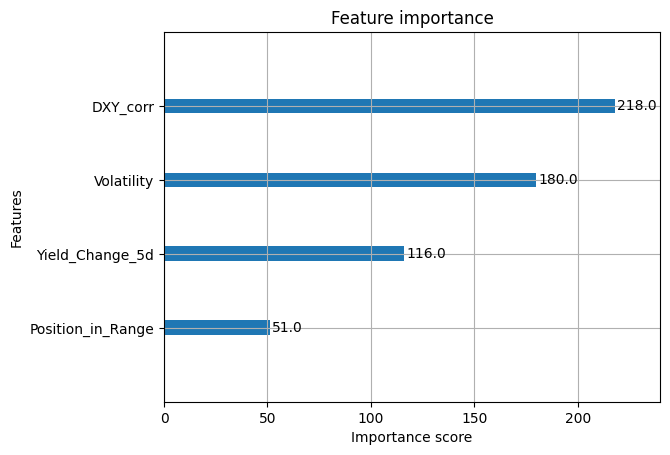

In [136]:
plt.figure(figsize=(10,6))
plot_importance(final_model, max_num_features=10)
plt.show()

In [137]:
import joblib

joblib.dump(final_model, 'gold_price_model1.joblib')

['gold_price_model1.joblib']